In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%precision 4

'%.4f'

## Model Algorithms

In [31]:
train_data_x = pd.DataFrame() 
train_data_y = pd.DataFrame()
test_data_x = pd.DataFrame()
test_data_y = pd.DataFrame()

def sigmoid(e):
    '''
    returns the sigmoid of the values
    '''
    return np.around((1/(1+np.exp(-e))),decimals=9)

def gradient_value_logistic(x,y,b):
    '''
    Returns the gradient value of the logistic funciton to be minimized 
    '''
    #print((np.matrix(y).T-sigmoid(np.matmul(x,b))).shape)
    return np.around(-np.matmul(x.T,(np.matrix(y).T-sigmoid(np.matmul(x,b)))),decimals=9)

#returns the gradient value
def function_value(x,y,b):
    '''
    returns the function value logistic function 
    '''
    return np.matmul(y.T,np.matmul(x,b))-np.log(1+(sigmoid(np.matmul(x,b))))

def bold_step(x,y,beta,beta_new,alpha=1):
    '''
    bold step: returns a higher alpha if the new value is greater than the last value(ascent here) else
    decrease the stepsize
    '''
    alpha_p = 1.05
    alpha_m = 0.05
    if ((function_value(x,y,beta_new)).all() < (function_value(x,y,beta)).all()):
        alpha*=alpha_p
    else:
        alpha*=alpha_m
    return alpha

def residual(f_prev,f_curr):
    '''
    difference between the last and the current function value
    '''
    return np.around(np.mean(np.abs(f_prev-f_curr)), decimals= 9)

def rmse(y,y_pred,eps = 1e-15):
    '''
    error funciton for the linear regression
    '''
    y = np.matrix(y).T
    #print(y.shape,y_pred.shape)
    return np.around(np.sqrt(np.mean(np.asarray(y-y_pred)**2)), decimals= 9)

def gradient_value_linear(x,y,b):
    '''
    gradient for linear regression
    '''
    y = np.matrix(y).T
    #print(x.shape,y.shape,b.shape)
    return np.around(-(np.matmul(2*x.T,(y-np.matmul(x,b)))), decimals=9)


def crossEntropy(y,y_pred,eps = 1e-15):
    '''
    log loss function implementation 
    '''
    y_pred=sigmoid(y_pred)
    #print(y_pred)
    #y = np.matrix(y).T
    return -np.sum(np.matmul(y.T,np.log(y_pred))+np.matmul((1-y).T,np.log(1-y_pred)))/len(y_pred)

def gradient_descent(train_data,test_data,beta_shape, col_name='y',hyper=[], N=0.00001, tol= 1e-6):
    '''
    Here we perform gradient descent by minimizing the gradient 
    '''
    error_train = {}
    error_test = {}
    iteration_error_train = {}
    iteration_error_test = {}
    hyperparams_train = {}
    hyperparams_test = {}
    train_batches = np.array_split(train_data, train_data.shape[0]/50)
    k = [0]  #do not regularize the beta
    for hp in hyper:
        alpha = hp[0]
        lamb = hp[1]
        #print(lamb)
        beta = np.ones((beta_shape,1))
        for it in range(N):
            #print(alpha,lamb)
            for x in (train_batches):
                y = x[col_name]
                x = x.drop(col_name,axis=1)
                y_pred = np.matmul(x,beta)
                gradient = - gradient_value_linear(x,y,beta)
                beta = beta + alpha*(gradient+2*lamb*np.vstack((k,beta[1:])))
            tst_loss,trn_loss = predict_linear(beta,train_data,test_data)
            iteration_error_train[it]=trn_loss
            iteration_error_test[it]=tst_loss
            #print(iteration_error_train)
        key = str(alpha) + ' ' + str(lamb)
        hyperparams_test[key] = iteration_error_test
        hyperparams_train[key] = iteration_error_train
    #plot(hyperparams_test)
    
    return hyperparams_test,hyperparams_train,beta

def gradient_descent_logistic(train_data,test_data,beta_shape, col_name='y',hyper=[], N=0.00001, tol= 1e-6):
    '''
    Here we perform gradient descent by minimizing the negative of the log likelihood
    '''
    error_train = {}
    error_test = {}
    iteration_error_train = {}
    iteration_error_test = {}
    hyperparams_train = {}
    hyperparams_test = {}
    train_batches = np.array_split(train_data, train_data.shape[0]/50)
    k = [0]  #do not regularize the beta
    for hp in hyper:
        alpha = hp[0]
        lamb = hp[1]
        #print(lamb)
        beta = np.ones((beta_shape,1))
        for it in range(N):
            #print(alpha,lamb)
            for x in (train_batches):
                y = x[col_name]
                x = x.drop(col_name,axis=1)
                y_pred = np.matmul(x,beta)
                #performing gradient descent inspite of the name 
                gradient = - gradient_value_logistic(x,y,beta)
                beta = beta + alpha*(gradient+2*lamb*np.vstack((k,beta[1:])))
                #print(beta.shape)
            tst_loss,trn_loss = predict_logistic(beta,train_data,test_data)
            iteration_error_train[it]=trn_loss
            iteration_error_test[it]=tst_loss
            #print(iteration_error_train)
        key = str(alpha) + ' ' + str(lamb)
        hyperparams_test[key] = iteration_error_test
        hyperparams_train[key] = iteration_error_train
    #plot(hyperparams_test)
    return hyperparams_test,hyperparams_train,beta

def predict_logistic(beta,train,test,col_name='y'):
    '''
    Measure the loss on the prediction (Logistic reg)
    '''
    #print(train_data_y.shape,y_pred_train.shape)
    test_loss = crossEntropy(test[col_name],np.matmul(test.drop(col_name,axis=1),beta),eps = 1e-15)
    #print(test_loss)
    train_loss = crossEntropy(train[col_name],np.matmul(train.drop(col_name,axis=1),beta),eps = 1e-15)
    #print(test_loss,train_loss)
    return test_loss,train_loss

def predict_linear(beta,train,test,col_name='quality'):
    '''
    Measure the loss on the prediction (Linear reg)
    '''
    #print(train_data_y.shape,y_pred_train.shape)
    test_loss = rmse(test[col_name],np.matmul(test.drop(col_name,axis=1),beta),eps = 1e-15)
    #print(test_loss)
    train_loss = rmse(train[col_name],np.matmul(train.drop(col_name,axis=1),beta),eps = 1e-15)
    #print(test_loss,train_loss)
    return test_loss,train_loss


def plot(hyperP_test,hyperP_train):
    '''
    Plots the residual and log loss curve
    '''
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(16,10))
    for hp, iter_loss in hyperP_test.items():
        ax1.plot(list(dict(hyperP_test[hp]).keys()),list(dict(hyperP_test[hp]).values()))
    for hp, iter_loss in hyperP_train.items():
        ax2.plot(list(dict(hyperP_train[hp]).keys()),list(dict(hyperP_train[hp]).values()))  
    ax1.legend(list(hyperP_train.keys()))
    ax2.legend(list(hyperP_test.keys()))
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Error')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Error') 
    ax1.set_title('Training Error')
    ax2.set_title('Test Error')
    ax1.grid()
    ax2.grid()
        
def combination(alpha,lambdas):
    '''
    Create the combinations of the hyperparameters
    '''
    combs = []
    for a in alpha:
        for l in lambdas:
            comb = [a,l]
            combs.append(comb)
    return combs

def grid_search_logistic(data_train,data_test,beta_shape,N=1,col_name='y',hyper=[]):
    '''
    Perform grid search for the Logistic Regression (uses logistic gradient and error function)
    '''
    a,l,e = [],[],[]
    hp_mse={}
    #iterate over the hyperparameters
    for hp in hyper:
        alpha = hp[0]
        lamb = hp[1]
        valid_index=0
        beta = np.ones((beta_shape,1))
        #generate the folds for the data
        average_mse={}
        for i in range(5):
            #create train and validation set out of the fold for each fold
            train_folds,valid_fold = fold_data(data_train,i)
            for fold in train_folds:
                #split the fold into batches of 50
                train_batches = np.array_split(fold, fold.shape[0]/50)
                for it in range(N):
                    #print(alpha,lamb)
                    for x in (train_batches):
                        y = x[col_name]
                        x = x.drop(col_name,axis=1)
                        y_pred = np.matmul(x,beta)
                        gradient = - gradient_value_logistic(x,y,beta)
                        beta = beta + alpha*(gradient+2*lamb*beta)
            #track loss after each fold pass
            average_mse[i] = crossEntropy(valid_fold[col_name],np.matmul(valid_fold.drop(col_name,axis=1),beta),eps = 1e-15)
        #print(iteration_error_train)
        a.append(alpha),l.append(lamb),e.append(np.mean(list(average_mse.values())))
        #plot(hyperparams_test)
    return a,l,e

def grid_search_linear(data_train,data_test,beta_shape,N=1,col_name='quality',hyper=[]):
    '''
    Perform grid search for the Linear Regression  (uses linear gradient and error function)
    '''
    hp_mse={}
    a,l,e = [],[],[]
    for hp in hyper:
        alpha = hp[0]
        lamb = hp[1]
        valid_index=0
        beta = np.ones((beta_shape,1))
        #generate the folds for the data
        average_mse={}
        for i in range(5):
            train_folds,valid_fold = fold_data(data_train,i)
            for fold in train_folds:
                train_batches = np.array_split(fold, fold.shape[0]/50)
                for it in range(N):
                    #print(alpha,lamb)
                    for x in (train_batches):
                        y = x[col_name]
                        x = x.drop(col_name,axis=1)
                        y_pred = np.matmul(x,beta)
                        gradient = - gradient_value_linear(x,y,beta)
                        beta = beta + alpha*(gradient+2*lamb*beta)
            #track loss after each fold pass
            average_mse[i] = rmse(valid_fold[col_name],np.matmul(valid_fold.drop(col_name,axis=1),beta),eps = 1e-15)
        #print(iteration_error_train)
        a.append(alpha),l.append(lamb),e.append(np.mean(list(average_mse.values())))
        #hp_mse[key] = 
        #plot(hyperparams_test
    return a,l,e

def fold_data(data,valid_index):
    '''
    split the data into k folds
    '''
    #perform k fold on train data
    folds = p
    valid_set = folds[valid_index]
    del folds[valid_index]
    return folds,valid_set

def shuffle_slice(data):
    '''
    create the test and train split out of it 
    '''
    data_train = data.sample(frac=0.8)
    data_test = data.sample(frac = 0.2)
    return data_train,data_test

## Bank Data 

- We load the data and view the head to understand the data and it's feature

In [32]:
bank = pd.read_csv(r'C:\Users\Anurag\Desktop\ML_LAB\ML LAB 5\bank-additional-full.csv', sep=';')
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


- We remove all the values having 'unknown' data since they cannot contribute to the prediction 
- There are many ways of removing the missing values(use mean values, remove the rows or by using regression for finding the values
- We find the percentage of values in each column having unknown values by intially substituting the unknown values as na and then counting the NA values
- Following this we drop the rows having NA values/


In [33]:
bank.replace(["unknown"],np.nan,inplace=True)
print(bank.isna().sum()/bank.shape[0])
bank.dropna(inplace=True)

age               0.000000
job               0.008012
marital           0.001942
education         0.042027
default           0.208726
housing           0.024036
loan              0.024036
contact           0.000000
month             0.000000
day_of_week       0.000000
duration          0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.000000
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
nr.employed       0.000000
y                 0.000000
dtype: float64


- There were values mentioned in the dataset as 'nonexistent'
- I replaced the values as na, and counted their presence in ach columns, since 'poutcome' has nearly 80% of the data as 'nonexistent' it is wise to drop that column entirely

In [34]:
bank.replace(["nonexistent"],np.nan,inplace=True)
print(bank.isna().sum()/bank.shape[0])
bank.drop(columns='poutcome',inplace=True)

age               0.000000
job               0.000000
marital           0.000000
education         0.000000
default           0.000000
housing           0.000000
loan              0.000000
contact           0.000000
month             0.000000
day_of_week       0.000000
duration          0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.847415
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
nr.employed       0.000000
y                 0.000000
dtype: float64



- Now we identify the list of unique values for each category, the reason behind using this is to simply use boolean substitution and also to identify any ordinal variables
- columns such as contact, default, housing and so on can subsitute value of 1 and 0 for their respective values



In [35]:
for col in bank.select_dtypes(exclude=[np.number]).columns:
    print(col, "--->",bank[col].unique())

job ---> ['housemaid' 'services' 'admin.' 'technician' 'blue-collar' 'unemployed'
 'retired' 'entrepreneur' 'management' 'student' 'self-employed']
marital ---> ['married' 'single' 'divorced']
education ---> ['basic.4y' 'high.school' 'basic.6y' 'professional.course' 'basic.9y'
 'university.degree' 'illiterate']
default ---> ['no' 'yes']
housing ---> ['no' 'yes']
loan ---> ['no' 'yes']
contact ---> ['telephone' 'cellular']
month ---> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week ---> ['mon' 'tue' 'wed' 'thu' 'fri']
y ---> ['no' 'yes']


- We start by replacing the values of the resultant columns with one hot encoding

In [36]:
bank['y'] = bank['y'].replace(to_replace={'yes':1,'no':0})

#### Feature Selection

   - Since we had a large number of features to select from, each of which were divide in some category, I used the features of all these categories to perform a correlation study to pick the most relevant one of them
   - 4 categories mentioned in the dataset were:

#### Feature Category of Bank Campaign

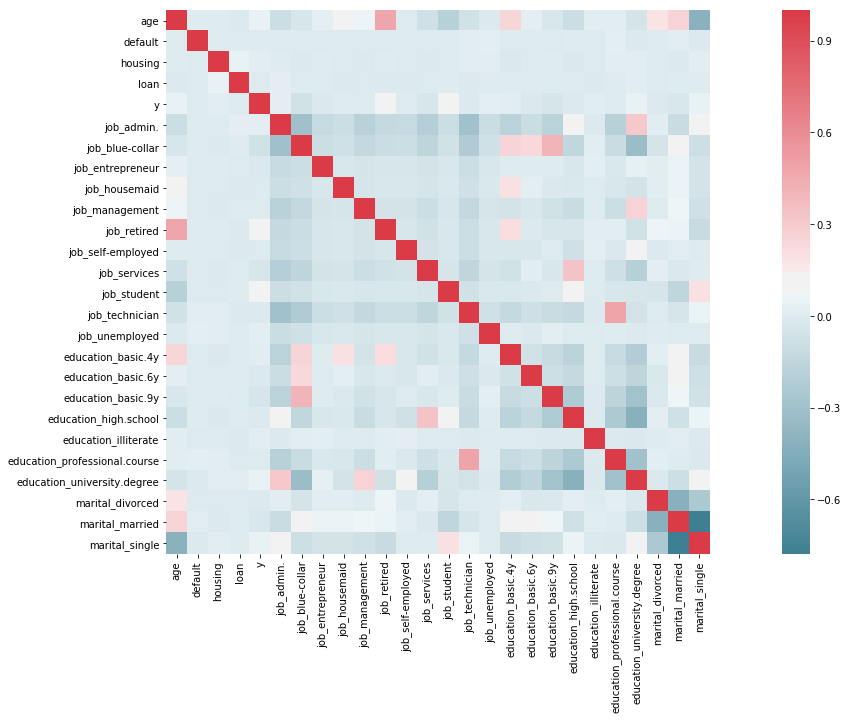

In [37]:
bank_client = bank[['age','job', 'education','marital','default','housing','loan','y']]
bank_client['default'] = bank_client['default'].replace(to_replace={'yes':1,'no':0})
bank_client['housing'] = bank_client['housing'].replace(to_replace={'yes':1,'no':0})
bank_client['loan'] = bank_client['loan'].replace(to_replace={'yes':1,'no':0})
non_num = ['job', 'education','marital',]
bank_client = pd.concat([bank_client.drop(non_num, axis=1), pd.get_dummies(bank_client[non_num])], axis=1)
bank_client.head()
f, ax = plt.subplots(figsize=(26, 10))
corr = bank_client.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


 - Although this heatmap looks pretty huge, we can still use some very useful inferences to undestand the relationship between the features of our dataset
 - There is a positive correaltion between job_retired and age, indicating that we can choose one parameter rather than picking both
 - There is also a correlation between the jobs and education, for example, blue collar job have correlation with education_basic 4,6 and 9y.
 - There is also a postive correlation between the age and marital_marriage



#### Feature Category of Bank Contact to Client Data

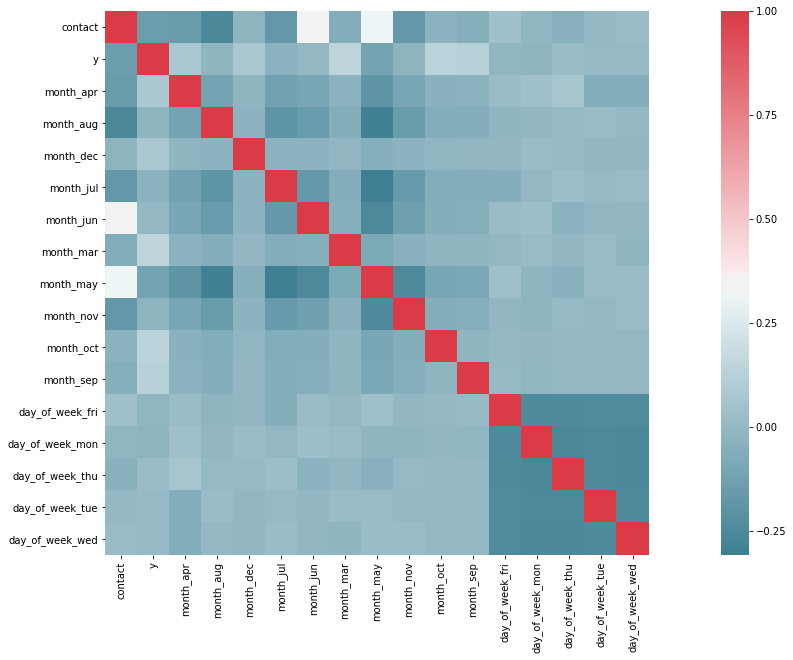

In [38]:
bank_contact = bank[['contact','month', 'day_of_week','y']]
bank_contact['contact'] = bank_contact['contact'].replace(to_replace={'telephone':1,'cellular':0})
non_num = ['month', 'day_of_week']
bank_contact = pd.concat([bank_contact.drop(non_num, axis=1), pd.get_dummies(bank_contact[non_num])], axis=1)
bank_contact.head()
f, ax = plt.subplots(figsize=(26, 10))
corr = bank_contact.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

- Since this aspect of feature informs us about the last contact of the current campaign, this should not impact the prediction of the model and hence we can ignore these features

#### Feature Category of Bank Campaign Data

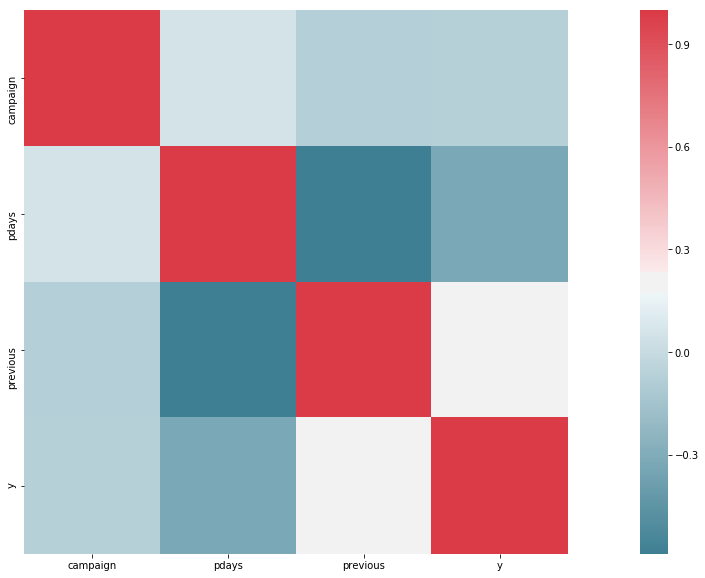

In [39]:
bank_campaign = bank[['campaign','pdays', 'previous','y']]
f, ax = plt.subplots(figsize=(26, 10))
corr = bank_campaign.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

- As we can see 'pdays' or 'number of days that passed by after the client was last contacted from a previous campaign' can actually impact the client's decision to buy a bank deposit

#### Feature Category of Social Data

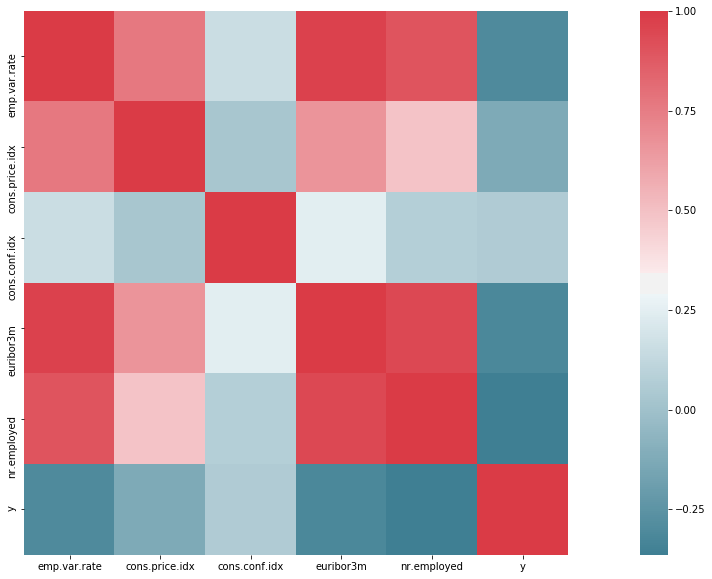

In [40]:
bank_social = bank[['emp.var.rate','cons.price.idx', 'cons.conf.idx','euribor3m','nr.employed','y']]
f, ax = plt.subplots(figsize=(26, 10))
corr = bank_social.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

- Social data represents the socio-economic data and as we can observe there is some strong negative correlation between nr.employed emp.var.rate, euribor3m and response variable
- Also 'nr.employed' is positively correlated with 'euribor3m','emp.var.rate' and 'cons.price.idx'



#### Model Creation

- We choose age, education,pdays, default and housing as our feature
- we convert the education column to one hot encoding
- Add a bias column to the data at index 0
- Create a response variable using the 'y' column



In [41]:
bank = bank[['age','education','pdays','default','housing','loan','y']]
#normalize the data
bank['default'] = bank['default'].replace(to_replace={'yes':1,'no':0})
bank['housing'] = bank['housing'].replace(to_replace={'yes':1,'no':0})
bank['loan'] = bank['loan'].replace(to_replace={'yes':1,'no':0})
non_num = ['education']
bank = pd.concat([bank.drop(non_num, axis=1), pd.get_dummies(bank[non_num])], axis=1)
min_val = bank.min()
max_val = bank.max()
bank = (bank-bank.min())/(bank.max()-bank.min())
#add bias column at index 0
bank.insert(0,'Bias',np.ones(30488))
#creating the Price column as predictor column
#bank_response = bank['y']
#bank.drop('y',inplace=True, axis = 1)   

### miniBatch Gradient Descent using Ridge Regression with batch size = 50 

In [42]:
hp = combination([1e-1,1e-3,1e-5],[0.002,0.05,0.90])
data_train,data_test = shuffle_slice(bank)
h_test,h_train ,_= gradient_descent_logistic(data_train,data_test,beta_shape=13, col_name='y',hyper=hp, N=50, tol= 1e-6)

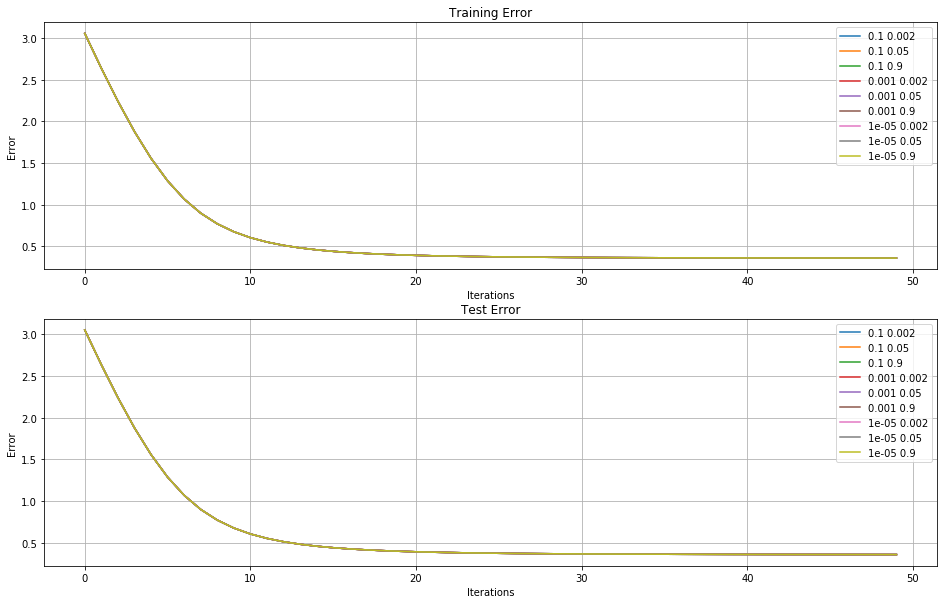

In [43]:
plot(h_test,h_train)

### Performing Grid Search for Hyperparameter search, using 5-fold cross validation 

In [44]:
hp = combination([1e-1,1e-2,1e-3],[0.002,0.005,0.008])
data_train,data_test = shuffle_slice(bank)
a,b,c = grid_search_logistic(data_train,data_test,beta_shape = 13,N=1,col_name='y',hyper=hp)

In [45]:
print("Alpha","--","Lambda","--","Error")
for x,y,z in zip(a,b,c):
    print(x,"--",y,"--",z)

Alpha -- Lambda -- Error
0.1 -- 0.002 -- 0.36726379822671595
0.1 -- 0.005 -- 0.367390413395417
0.1 -- 0.008 -- 0.3681199387967681
0.01 -- 0.002 -- 0.3431153457422778
0.01 -- 0.005 -- 0.34310804584789156
0.01 -- 0.008 -- 0.34311405379260324
0.001 -- 0.002 -- 0.3491648686810654
0.001 -- 0.005 -- 0.3491320255001188
0.001 -- 0.008 -- 0.34909948770388943


### Plotting the alpha,lambda and RMSE for each combinations

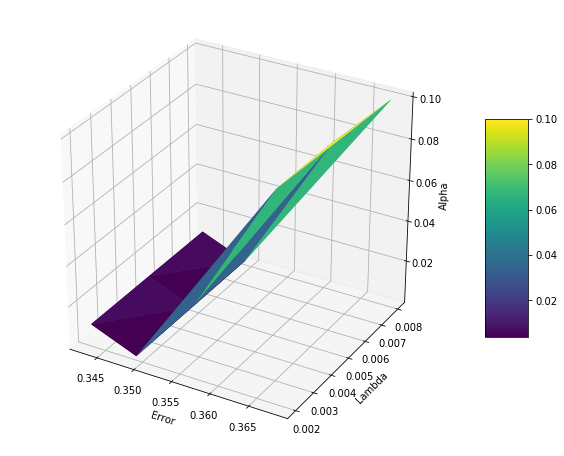

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.plot_trisurf(c, b, a, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Error')
ax.set_ylabel('Lambda')
ax.set_zlabel('Alpha')


surf=ax.plot_trisurf(c, b, a, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()


### Using the best alpha and lambda for model

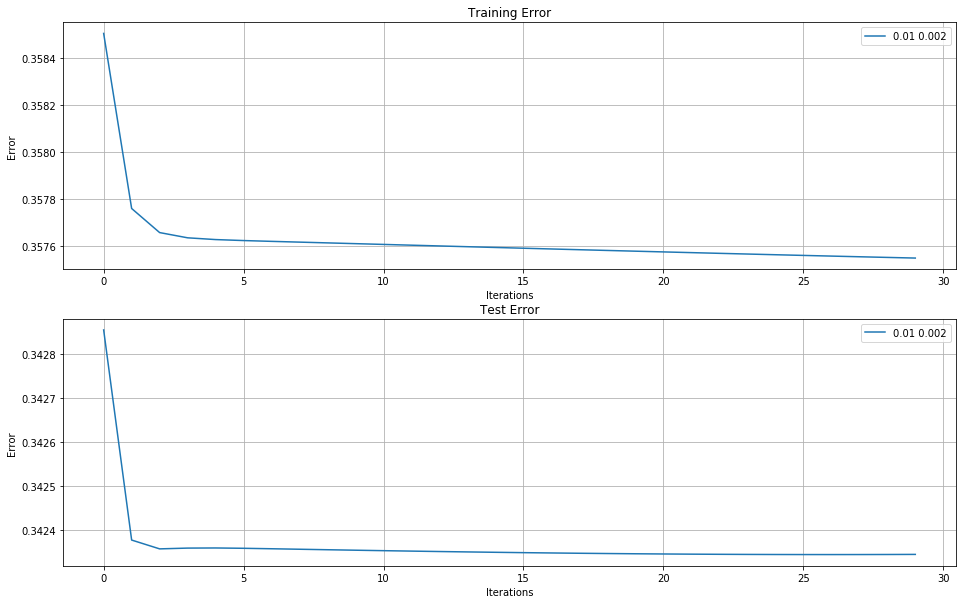

In [47]:
h_test,h_train,beta = gradient_descent_logistic(data_train,data_test,beta_shape=13, col_name='y',hyper=list([[0.01,0.002]]), N=30, tol= 1e-6)
plot(h_test,h_train)

In [48]:
test,train = predict_logistic(beta,data_train,data_test,col_name='y')
print("Error on test",test,"Error on train",train)

Error on test 0.3575493642162871 Error on train 0.3423452904770241


## Redwine and White Wine

In [49]:
wine_quality_red = pd.read_csv(r'D:\Exercises\ML Lab\winequality-red.csv', sep=';')
wine_quality_white = pd.read_csv(r'D:\Exercises\ML Lab\winequality-white.csv', sep=';')

### We now see the columns which are non numeric and find any NA value 

In [50]:
non_num_wine_quality_red = wine_quality_red.select_dtypes(exclude=np.number).columns  #get the non numeric columns
len(non_num_wine_quality_red) #returned 0
#wine_quality_red= pd.get_dummies(wine_quality_red[non_num_wine_quality_red]) #since there are no non numeric columns no dummies
wine_quality_red.isna().any().tolist().count(True)   #count any undefined values

0

### We now plot the correlation matrix to find the correlation between the features and the response column

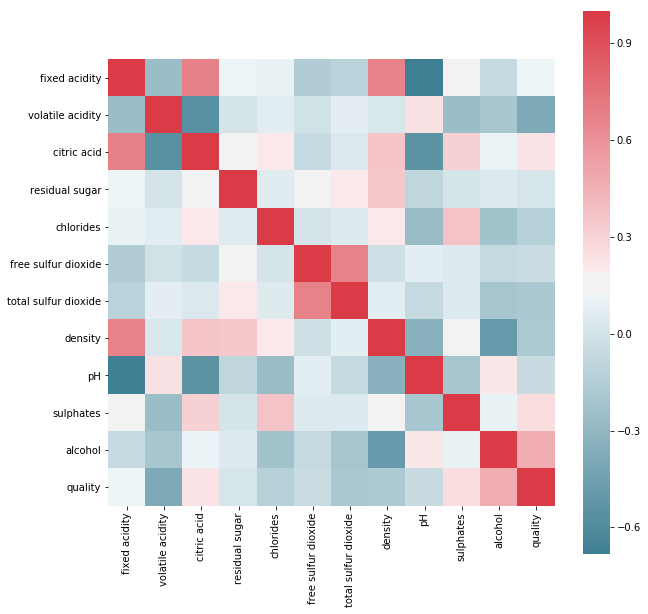

In [51]:
#wine_quality_red = pd.read_csv(r'D:\Exercises\ML Lab\winequality-red.csv', sep=';')
f, ax = plt.subplots(figsize=(10, 10))
corr = wine_quality_red.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### As can be seen from correlation plot, there exist a very high correlation between alcohol, sulphates, citric acid and quality. There also is a very correlation between citric acid and sulphates, thus we can choose to drop one column. Thus, I selected two columns Alcohol and Sulphates feature to predict Quality

In [52]:
wine_quality_red = wine_quality_red[['alcohol','sulphates','quality']]

### Normalizing the data and adding the bias

In [53]:
#normalize the data
wine_quality_red = (wine_quality_red-wine_quality_red.min())/(wine_quality_red.max()-wine_quality_red.min())
#add bias column at index 0
wine_quality_red.insert(0,'Bias',np.ones(1599))

### miniBatch Gradient Descent using Ridge Regression with batch size = 50 

In [54]:
hp = combination([1e-1,1e-3,1e-5],[0.002,0.05,0.90])
data_train,data_test = shuffle_slice(wine_quality_red)
h_test,h_train,_ = gradient_descent(data_train,data_test,beta_shape=3, col_name='quality',hyper=hp, N=50, tol= 1e-6)

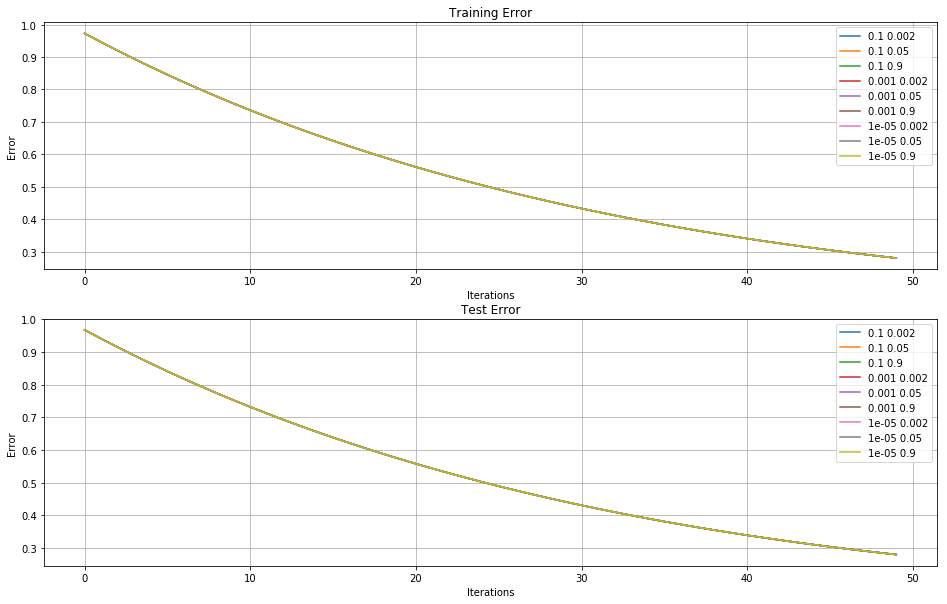

In [55]:
plot(h_test,h_train)

### Performing Grid Search for Hyperparameter search, using 5-fold cross validation 

In [56]:
hp = combination([1e-2,1e-3,1e-4],[0.002,0.005,0.008])
data_train,data_test = shuffle_slice(wine_quality_red)
a,b,c = grid_search_linear(data_train,data_test,beta_shape = 3,N=5,col_name='quality',hyper=hp)
print("Alpha","--","Lambda","--","Error")
for x,y,z in zip(a,b,c):
    print(x,"--",y,"--",z)

Alpha -- Lambda -- Error
0.01 -- 0.002 -- 0.1408350542
0.01 -- 0.005 -- 0.1408495458
0.01 -- 0.008 -- 0.1408645824
0.001 -- 0.002 -- 0.14629852040000002
0.001 -- 0.005 -- 0.14633840920000002
0.001 -- 0.008 -- 0.14637851340000002
0.0001 -- 0.002 -- 0.1997728232
0.0001 -- 0.005 -- 0.199793367
0.0001 -- 0.008 -- 0.19981392


### Plotting the alpha,lambda and RMSE for each combinations

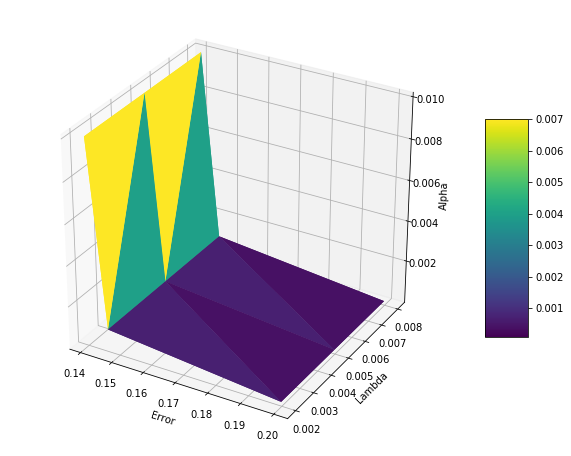

In [57]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.plot_trisurf(c, b, a, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Error')
ax.set_ylabel('Lambda')
ax.set_zlabel('Alpha')
surf=ax.plot_trisurf(c, b, a, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()

### Performing the prediction on best hyperparameter

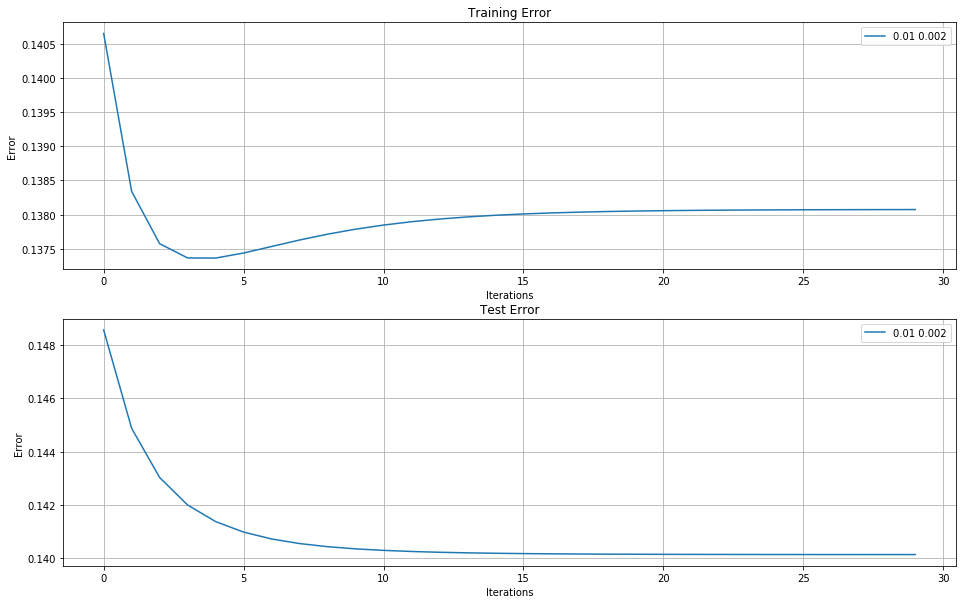

In [58]:
h_test,h_train,beta = gradient_descent(data_train,data_test,beta_shape=3, col_name='quality',hyper=list([[0.01,0.002]]), N=30, tol= 1e-6)
plot(h_test,h_train)

In [59]:
test,train = predict_linear(beta,data_train,data_test,col_name='quality')
print("Error on test",test,"Error on train",train)

Error on test 0.138072372 Error on train 0.140129572


## White wine
- Find any non numeric data columns
- Find any missing values

In [60]:
non_num_wine_quality_white = wine_quality_white.select_dtypes(exclude=np.number).columns #get the non numeric columns
len(non_num_wine_quality_white)   #returned 0
#wine_quality_red= pd.get_dummies(wine_quality_red[non_num_wine_quality_red])  #since there are no non numeric columns no dummies
wine_quality_white.isna().any().tolist().count(True)    #count any undefined values

0

- Find the correlation to select the features

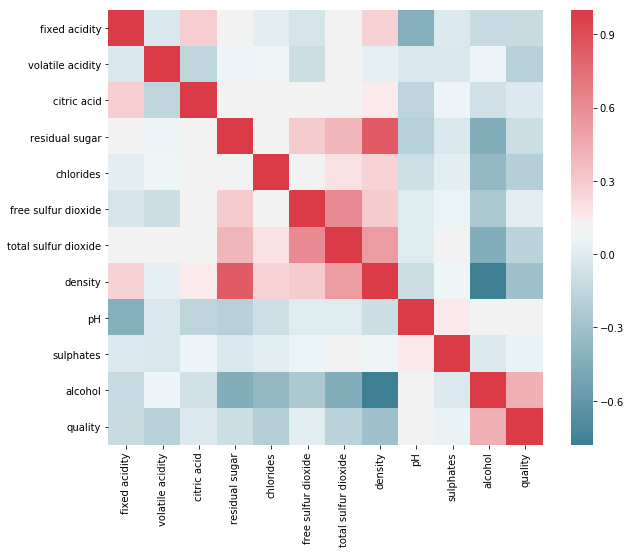

In [61]:
#wine_quality_white = pd.read_csv(r'D:\Exercises\ML Lab\winequality-white.csv', sep=';')
f, ax = plt.subplots(figsize=(10,8))
corr = wine_quality_white.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### As can be seen from correlation plot, there exist a very high correlation between alcohol and quality. I also selected the pH feature since the performance after adding pH as a single feature was better compared to adding other features in the first step of forward variable selection regression process

In [62]:
wine_quality_white = wine_quality_white[['alcohol','pH','quality']]

- Normalize the data and insert the bias column

In [63]:
#normalize the data
wine_quality_white = (wine_quality_white-wine_quality_white.min())/(wine_quality_white.max()-wine_quality_white.min())
#add bias column at index 0
wine_quality_white.insert(0,'Bias',np.ones(4898))

### miniBatch Gradient Descent using Ridge Regression with batch size = 50 

In [64]:
hp = combination([1e-1,1e-3,1e-5],[0.002,0.05,0.90])
data_train,data_test = shuffle_slice(wine_quality_white)
h_test,h_train,_ = gradient_descent(data_train,data_test,beta_shape=3, col_name='quality',hyper=hp, N=50, tol= 1e-6)

### Performing Grid Search for Hyperparameter search, using 5-fold cross validation 

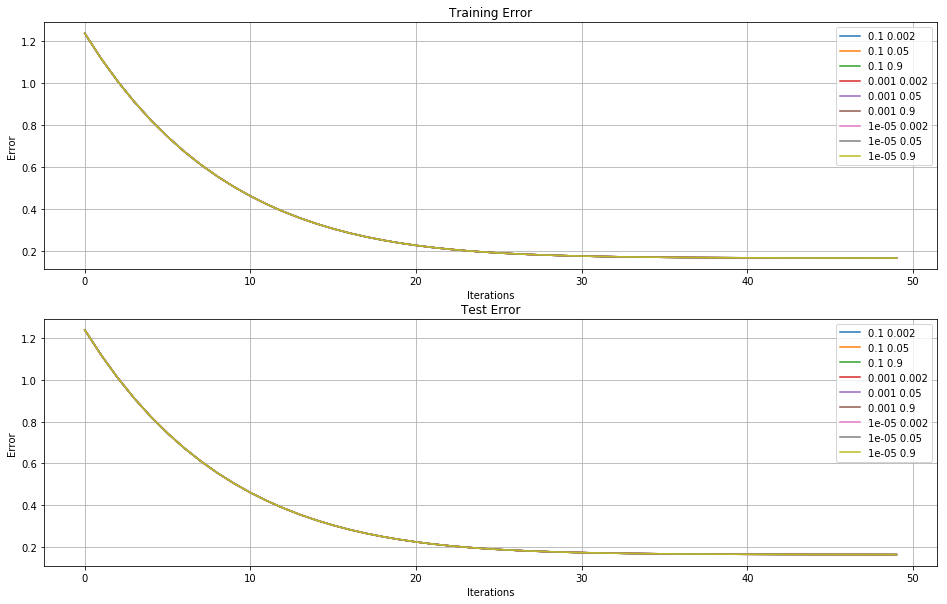

In [65]:
plot(h_test,h_train)

In [66]:
hp = combination([1e-2,1e-3,1e-4],[0.002,0.005,0.008])
data_train,data_test = shuffle_slice(wine_quality_red)
a,b,c = grid_search_linear(data_train,data_test,beta_shape = 3,N=5,col_name='quality',hyper=hp)
print("Alpha","--","Lambda","--","Error")
for x,y,z in zip(a,b,c):
    print(x,"--",y,"--",z)

Alpha -- Lambda -- Error
0.01 -- 0.002 -- 0.141176737
0.01 -- 0.005 -- 0.1411922088
0.01 -- 0.008 -- 0.1412080808
0.001 -- 0.002 -- 0.1478436712
0.001 -- 0.005 -- 0.1478827244
0.001 -- 0.008 -- 0.1479219934
0.0001 -- 0.002 -- 0.20018499100000003
0.0001 -- 0.005 -- 0.20020501900000004
0.0001 -- 0.008 -- 0.2002250562


### Plotting the alpha,lambda and RMSE for each combinations

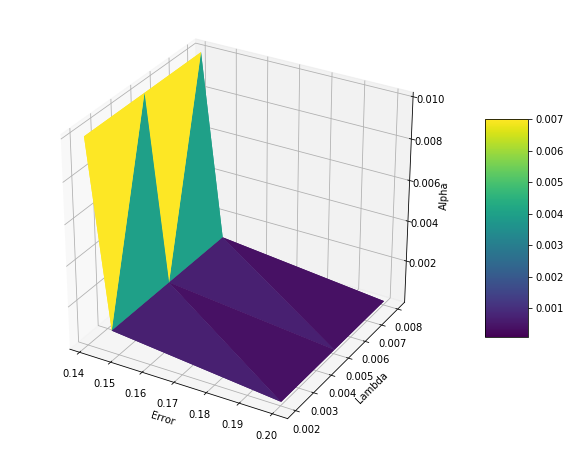

In [67]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.plot_trisurf(c, b, a, cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Error')
ax.set_ylabel('Lambda')
ax.set_zlabel('Alpha')


surf=ax.plot_trisurf(c, b, a, cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()


### Performing prediction for the best hyperparameter

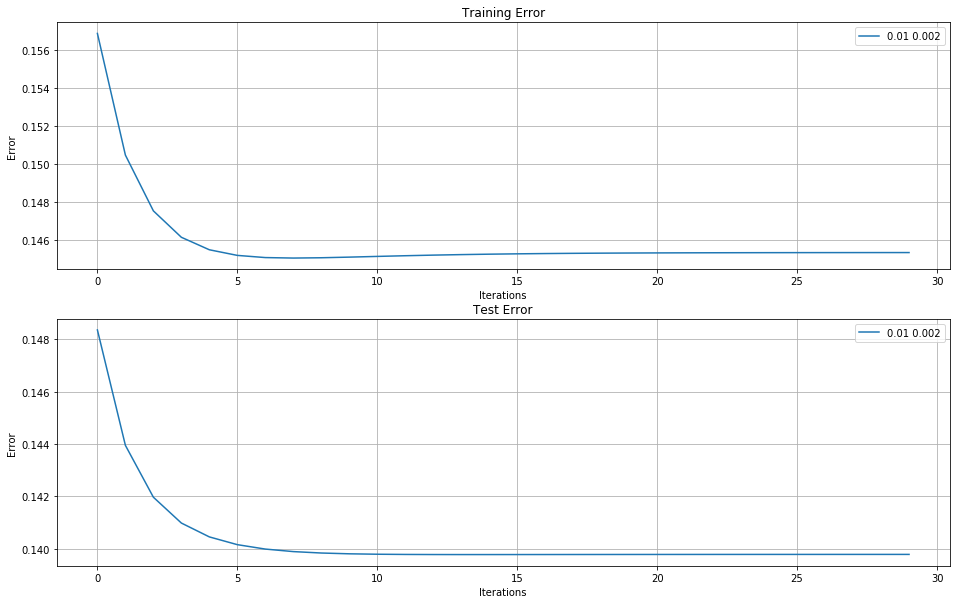

In [68]:
h_test,h_train,beta = gradient_descent(data_train,data_test,beta_shape=3, col_name='quality',hyper=list([[0.01,0.002]]), N=30, tol= 1e-6)
plot(h_test,h_train)

In [69]:
test,train = predict_linear(beta,data_train,data_test,col_name='quality')
print("Error on test",test,"Error on train",train)

Error on test 0.145315097 Error on train 0.139786576


#### In all cases after grid search the model converges faster and quickly. Thus grid search allows us to have better results by selecting best combination of hyperparameters. This alos helps in reducing the number of iterations required for converging

#### Also, post the selection from grid search the model produces even lower error on the test set
